In [14]:
#example from dowhy docs

import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

In [8]:
data= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)
print(data.head())
print('--------------')
col = ['treatment', 'y_factual', 'y_cfactual', 'mu0', 'mu1' ,]
for i in range(1,26):
    col.append('x'+str(i))
data.columns = col
data = data.astype({'treatment':'bool'}, copy=False)


print(data.head())
#y_factual+y_cfactual=1, mu_0,mu_1 mean on y_factual, y_cfactual w and wo treatment



   0         1         2         3         4         5         6         7   \
0   1  5.599916  4.318780  3.268256  6.854457 -0.528603 -0.343455  1.128554   
1   0  6.875856  7.856495  6.636059  7.562718 -1.736945 -1.802002  0.383828   
2   0  2.996273  6.633952  1.570536  6.121617 -0.807451 -0.202946 -0.360898   
3   0  1.366206  5.697239  1.244738  5.889125  0.390083  0.596582 -1.850350   
4   0  1.963538  6.202582  1.685048  6.191994 -1.045229 -0.602710  0.011465   

         8         9   ...  20  21  22  23  24  25  26  27  28  29  
0  0.161703 -0.316603  ...   1   1   1   1   0   0   0   0   0   0  
1  2.244320 -0.629189  ...   1   1   1   1   0   0   0   0   0   0  
2 -0.879606  0.808706  ...   1   0   1   1   0   0   0   0   0   0  
3 -0.879606 -0.004017  ...   1   0   1   1   0   0   0   0   0   0  
4  0.161703  0.683672  ...   1   1   1   1   0   0   0   0   0   0  

[5 rows x 30 columns]
--------------
   treatment  y_factual  y_cfactual       mu0       mu1        x1        

In [9]:
xs = ""
for i in range(1,26):
    xs += ("x"+str(i)+"+")
model=CausalModel(
        data = data,
        treatment='treatment',
        outcome='y_factual',
        common_causes=xs.split('+')
        )


INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['y_factual']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


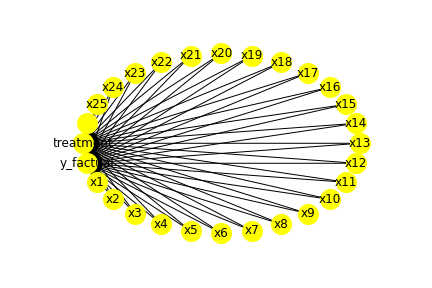

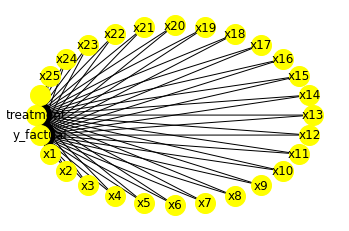

In [12]:
model.view_model()
from IPython.display import Image,display
display(Image(filename="causal_model.png"))

<h5>Estimate the causal effect</h5>
causal effect = $E(Y^1-Y^0)$ 
<p>Expectation of (outcome with treatment minus the outcome without treatment)</p>

In [10]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['', 'x13', 'x7', 'x5', 'x20', 'x2', 'x11', 'x15', 'x16', 'x10', 'x6', 'x1', 'x25', 'x23', 'x8', 'x18', 'x24', 'x14', 'x22', 'x3', 'x9', 'x21', 'x12', 'x4', 'x19', 'x17']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(y_factual|x13,x7,x5,x20,x2,x11,x15,x16,x10,x6,x1,x25,
d[treatment]                                                                  

                                                 
x23,x8,x18,x24,x14,x22,x3,x9,x21,x12,x4,x19,x17))
                                                 
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→y_factual then P(y_factual|treatment,x13,x7,x5,x20,x2,x11,x15,x16,x10,x6,x1,x25,x23,x8,x18,x24,x14,x22,x3,x9,x21,x12,x4,x19,x17,U) = P(y_factual|treatment,x13,x7,x5,x20,x2,x11,x15,x16,x10,x6,x1,x25,x23,x8,x18,x24,x14,x22,x3,x9,x21,x12,x4,x19,x17)
### Estimand : 2
Estimand name: iv
No such variable found!



In [13]:
# Estimate the causal effect and compare it with Average Treatment Effect
#test_signifance=True returns p-value
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))
data_1 = data[data["treatment"]==1]
data_0 = data[data["treatment"]==0]
print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17


                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     78.91
Date:                Mon, 14 Dec 2020   Prob (F-statistic):          6.10e-191
Time:                        13:01:47   Log-Likelihood:                -1138.1
No. Observations:                 747   AIC:                             2330.
Df Residuals:                     720   BIC:                             2455.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2206      0.448      4.957      0.0

In [16]:
#compare Average causal effect with propensity matching to linear regression
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching"
)

print("Causal Estimate is " + str(estimate.value))

print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Causal Estimate is 3.9791388232170393
ATE 4.021121012430829


In [ ]:
<h5>refute</h5>
placebo vs subset. 



In [19]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

print("------placebo----------")
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

print("------subset----------")
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17+w_random
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17


Refute: Add a Random Common Cause
Estimated effect:3.409737824402151
New effect:3.4089870162941045

------placebo----------


/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougcha

INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.cau

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.cau

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.cau

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.cau

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~placebo+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.cau

Refute: Use a Placebo Treatment
Estimated effect:3.409737824402151
New effect:-0.04572520467067575
p value:0.43000000000000005

------subset----------


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x13+x7+x5+x20+x2+x11+x15+x16+x10+x6+x1+x25+x23+x8+x18+x24+x14+x22+x3+x9+x21+x12+x4+x19+x17
/Users/dougchang/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy

Refute: Use a subset of data
Estimated effect:3.409737824402151
New effect:3.379134245719903
p value:0.38

